In [49]:
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Sequential 

In [82]:
img_size=256
btch_size=32

In [83]:
data=tf.keras.preprocessing.image_dataset_from_directory(
    "Potato",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=btch_size
)

Found 1500 files belonging to 3 classes.


In [84]:
class_names=data.class_names
class_names

['Potato___Early', 'Potato___Late', 'Potato___healthy']

In [85]:
len(data)

47

In [86]:
for image_batch,label_batch in data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 2 2 2 1 2 0 2 1 1 2 0 2 2 0 2 2 2 2 2 1 0 1 0 0 1 1 0 1 0 2]


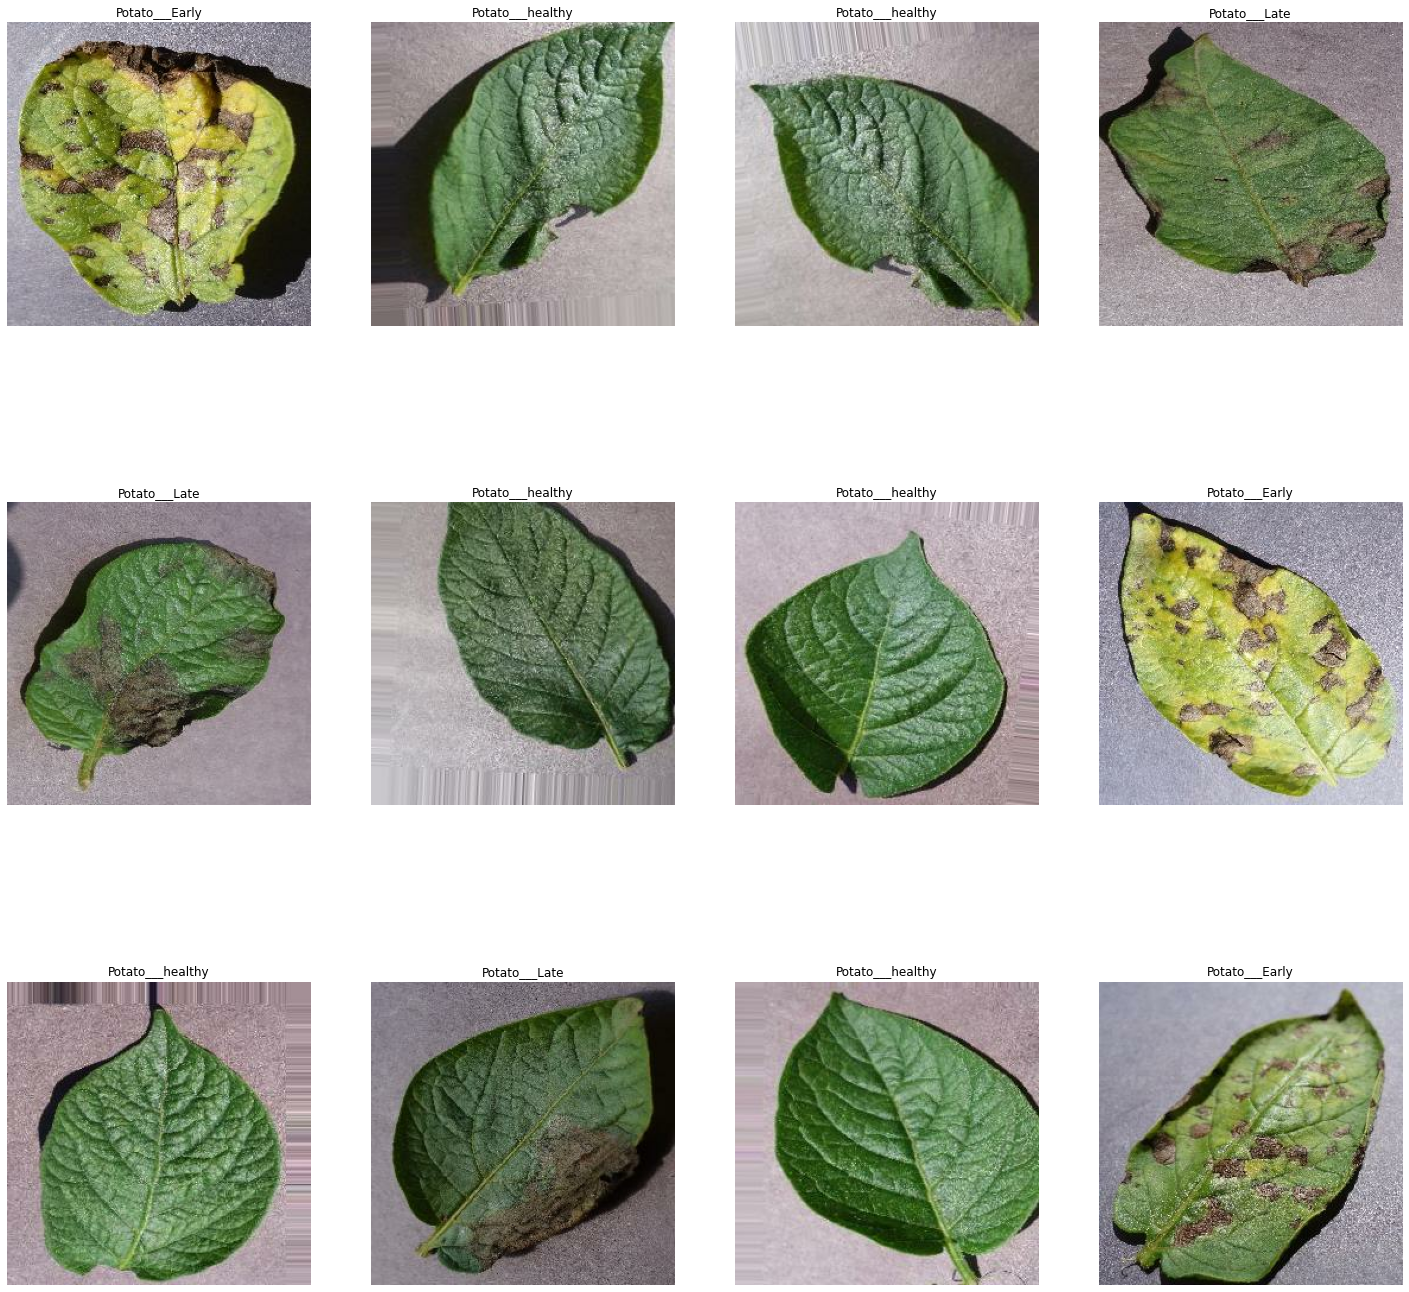

In [87]:
plt.figure(figsize=(25,25))
for image_batch,label_batch in data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [89]:
def get_dataset_split(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [90]:
train_ds,val_ds,test_ds=get_dataset_split(data)

In [91]:
len(train_ds)

37

In [92]:
len(val_ds)

4

In [93]:
len(test_ds)

6

In [94]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(img_size, img_size),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [95]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [100]:
n=3                  ##number of classes
input_shape=(32,img_size,img_size,3)
model=Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D(),
    
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(n,activation='softmax'),
])

In [102]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_19 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [103]:
model.compile(optimizer='adam',loss=SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'])

In [66]:
history = model.fit(
    train_ds,
    batch_size=btch_size,
    validation_data=val_ds,
    epochs=10,
)

Epoch 1/10
37/37 [==============================] - 84s 2s/step - loss: 1.0991 - Accuracy: 0.3390 - val_loss: 1.0787 - val_Accuracy: 0.3438
Epoch 2/10
37/37 [==============================] - 80s 2s/step - loss: 0.9558 - Accuracy: 0.5034 - val_loss: 0.6741 - val_Accuracy: 0.6406
Epoch 3/10
37/37 [==============================] - 79s 2s/step - loss: 0.5473 - Accuracy: 0.7737 - val_loss: 0.3978 - val_Accuracy: 0.8672
Epoch 4/10
37/37 [==============================] - 73s 2s/step - loss: 0.4166 - Accuracy: 0.8085 - val_loss: 0.3159 - val_Accuracy: 0.9062
Epoch 5/10
37/37 [==============================] - 64s 2s/step - loss: 0.3109 - Accuracy: 0.8910 - val_loss: 0.2584 - val_Accuracy: 0.8790
Epoch 6/10
37/37 [==============================] - 63s 2s/step - loss: 0.2987 - Accuracy: 0.8881 - val_loss: 0.3893 - val_Accuracy: 0.8672
Epoch 7/10
37/37 [==============================] - 64s 2s/step - loss: 0.2507 - Accuracy: 0.9008 - val_loss: 0.2063 - val_Accuracy: 0.9141
Epoch 8/10
37/37 [==

In [67]:
scores=model.evaluate(train_ds)

37/37 [==============================] - 17s 440ms/step - loss: 0.2320 - Accuracy: 0.9042


In [68]:
history

In [69]:
history.history.keys()

dict_keys(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'])

In [107]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

folder_paths = ["C:/Users/HP/FOML/Potato/Potato___Early", "C:/Users/HP/FOML/Potato/Potato___healthy", "C:/Users/HP/FOML/Potato/Potato___Late"]
image_data = []
labels = []

# Load images from each folder and assign labels
for i, folder_path in enumerate(folder_paths):
    print(folder_path)
    for filename in os.listdir(folder_path):
        if filename.endswith((".jpg",".png",".jpeg",".JPG")):
            img = cv2.imread(os.path.join(folder_path, filename))
            # Resize the image if needed
            # img = cv2.resize(img, (desired_width, desired_height))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
            flattened_img = img.flatten()
            image_data.append(flattened_img)
            labels.append(i)
    print(len(image_data))
print(len(image_data))

data = pd.DataFrame(image_data)
data['label'] = labels

X = data.iloc[:, :-1]  # Features
y = data['label']  # Labels


n_components = 0.95
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

C:/Users/HP/FOML/Potato/Potato___Early
500
C:/Users/HP/FOML/Potato/Potato___healthy
1000
C:/Users/HP/FOML/Potato/Potato___Late
1500
1500


In [108]:
X_pca.shape

(1500, 1264)

In [109]:
X.shape

(1500, 65536)

In [110]:
y.shape

(1500,)

In [111]:
n=3                  ##number of classes
input_shape=(1264,)
model1=Sequential([
    layers.Dense(32,activation='relu',input_shape=input_shape),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(n,activation='softmax'),
])

In [112]:
model1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['Accuracy'])

In [113]:
from tensorflow.keras.utils import to_categorical
y=pd.get_dummies(y)
y.head()

,0,1,2
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [114]:
y.shape

(1500, 3)

In [115]:
model1.fit(
    X_pca,y,
    epochs=10,
)

Epoch 1/10
47/47 [==============================] - 3s 5ms/step - loss: 8.2138 - Accuracy: 0.4080
Epoch 2/10
47/47 [==============================] - 0s 5ms/step - loss: 2.1764 - Accuracy: 0.5740
Epoch 3/10
47/47 [==============================] - 0s 5ms/step - loss: 0.7794 - Accuracy: 0.7720
Epoch 4/10
47/47 [==============================] - 0s 5ms/step - loss: 0.4342 - Accuracy: 0.8560
Epoch 5/10
47/47 [==============================] - 0s 4ms/step - loss: 0.2135 - Accuracy: 0.9360
Epoch 6/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0963 - Accuracy: 0.9733
Epoch 7/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0419 - Accuracy: 0.9880
Epoch 8/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0208 - Accuracy: 0.9973
Epoch 9/10
47/47 [==============================] - 0s 5ms/step - loss: 0.0069 - Accuracy: 1.0000
Epoch 10/10
47/47 [==============================] - 0s 4ms/step - loss: 0.0042 - Accuracy: 1.0000


actual label: Potato___healthy
1/1 [==============================] - 1s 585ms/step
predicted label: Potato___healthy


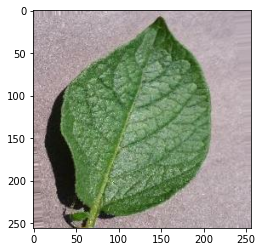

In [121]:
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()
    plt.imshow(first_image)
    print('actual label:',class_names[first_label])
    
    batch_prediction=model.predict(image_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])
    